# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Fixed Units Implementation

Fixed units position sizing technique is simply trading a fixed number of units each time you trade. Even if you have more capital, throughout the backtest you will continue to buy only the number of units you bought in your first trade.

In this notebook, you will learn to implement the fixed units position sizing technique on the index reversal strategy.
The notebook is divided into the following parts:

1. [Read the Data](#read)
1. [Fixed Units Calculation](#size)
1. [Portfolio Value Calculation](#calculate)
1. [Portion of Capital](#portion)
1. [Leverage Ratio](#leverage)
    
## Import Libraries

In [1]:
# Data manipulation
import pandas as pd

# Quantra function to analyse the performance
import sys
sys.path.append("..")
from data_modules.position_sizing_quantra import performance_analysis

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

<a id='read'></a>
## Read the Data

The SPY ETF data is read and the fixed units technique is applied to the index reversal strategy. The SPY ETF price is read from `SPY_data_15_59.csv` and the index reversal strategy's trading signal and the portfolio value are read from a file named `strategy_data.csv`.

The strategy data starting from 1st January 2005 is considered so that the position sizing techniques can be compared with the performance results of the index reversal strategy.

In [2]:
# Read the price data of one minute before the market close
spy_price = pd.read_csv(
    '../data_modules/SPY_data_15_59.csv', index_col=0, parse_dates=True)

# Set the date as the index for the price data
spy_price.index = pd.to_datetime(spy_price.index.date)

# Consider the data starting from 1st January 2005
spy_price = spy_price.loc['2005-01-01':]

# Read the signal and cumulative returns of the index reversal strategy
strategy = pd.read_csv('../data_modules/strategy_data.csv',
                       index_col=0, parse_dates=True)

# Preview the strategy data
strategy.head()

,signal,returns,cumulative_returns
2005-01-03,0,-0.000000,1.000000
2005-01-04,1,-0.000000,1.000000
2005-01-05,1,-0.003537,0.996463
2005-01-06,0,0.003296,0.999747
2005-01-07,0,-0.000000,0.999747


<a id='size'></a>
## Fixed Units Calculation

The fixed size is calculated by finding out the number of units bought in the first trade.

$$ \text{Number of units to trade} = \frac{\text{Initial capital}}{\text{Price on date of the first trade}} $$

In [3]:
# Define the initial capital
initial_capital = 10000

# First trading day price (4th January 2005)
first_trade_price = 118.74

# Calculate the size of each fixed unit trade (rounded to the lowest integer value)
num_of_units = int(initial_capital / first_trade_price)

print(f"The number of units to buy is {num_of_units}.")

The number of units to buy is 84.


<a id='calculate'></a>
## Portfolio Value Calculation

The total portfolio value is calculated by taking the trades on the days the index reversal strategy trades. The profit-and-loss (`pnl`) is calculated by taking the difference of the close prices. This is done assuming a daily rebalancing of the portfolio as per the strategy signal. 

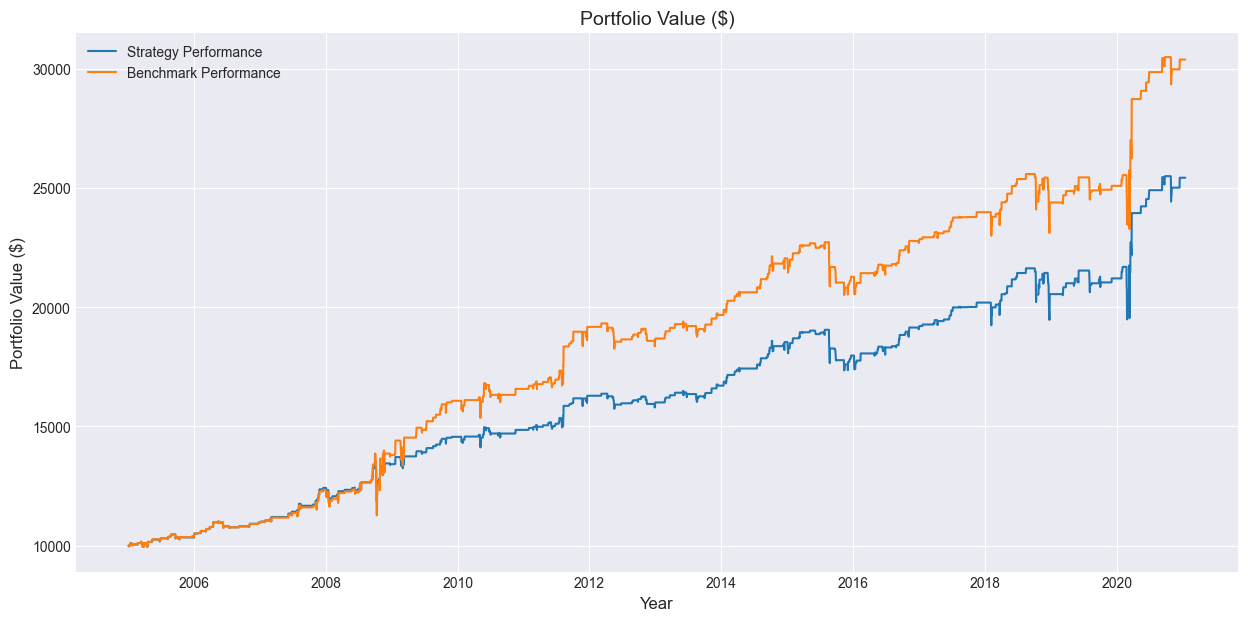

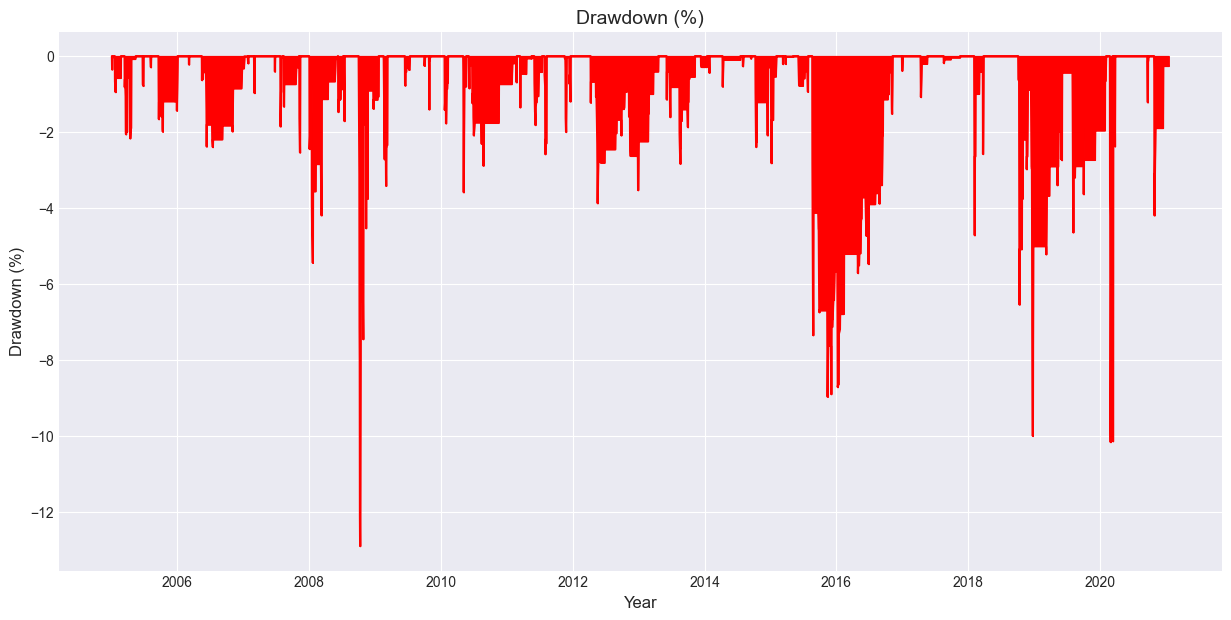

Total returns: 154.39%
Annualised returns (CAGR): 6.01%
Maximum drawdown (MDD): -12.9%
Return-to-MDD ratio: 0.47


In [4]:
# Calculate the profit and loss per unit of the asset
spy_price['pnl'] = spy_price['Close'].diff()

# Dataframe to store strategy returns for fixed unit technique
fixed_units = pd.DataFrame()

# Caclculate the profit and loss for the strategy with fixed units
fixed_units['pnl'] = spy_price['pnl'] * \
    strategy['signal'].shift(1) * num_of_units

# Calculate the portfolio value after implementation of the fixed units
fixed_units['portfolio_value'] = fixed_units['pnl'].cumsum() + initial_capital

# Calculate the performance metrics and plot the portfolio value alongwith the benchmark
performance_analysis(
    fixed_units['portfolio_value'].dropna(),
    strategy['cumulative_returns']*initial_capital
)

<a id='portion'></a>
## Portion of Capital

The portion of capital is the wealth used in each trade. Since the number of units is fixed, the wealth used per trade is the number of units (`num_of_units`) multiplied by the price of the asset(`spy_price['Close']`). This wealth is calculated whenever the strategy places a trade (multiplied by signal `strategy['signal']`).

In [5]:
# Portion of capital used
fixed_units['portion_of_capital'] = num_of_units * spy_price['Close'] * strategy['signal']

### Portion of Capital Plotting Utility

A function to plot the portion of capital is defined so that you can easily plot this metric for the upcoming position sizing techniques.

The portion of capital used plotting function is called `plot_portion_of_capital`. This function is placed in the `position_sizing_quantra.py` file located in the `data_modules` folder.

The `plot_portion_of_capital` function accepts two arguments.
1. `portion_of_capital_used`: The portion of the capital used by the strategy.
1. `total_portfolio_value`: The portfolio value of the benchmark strategy to compare the performance. This argument is optional.

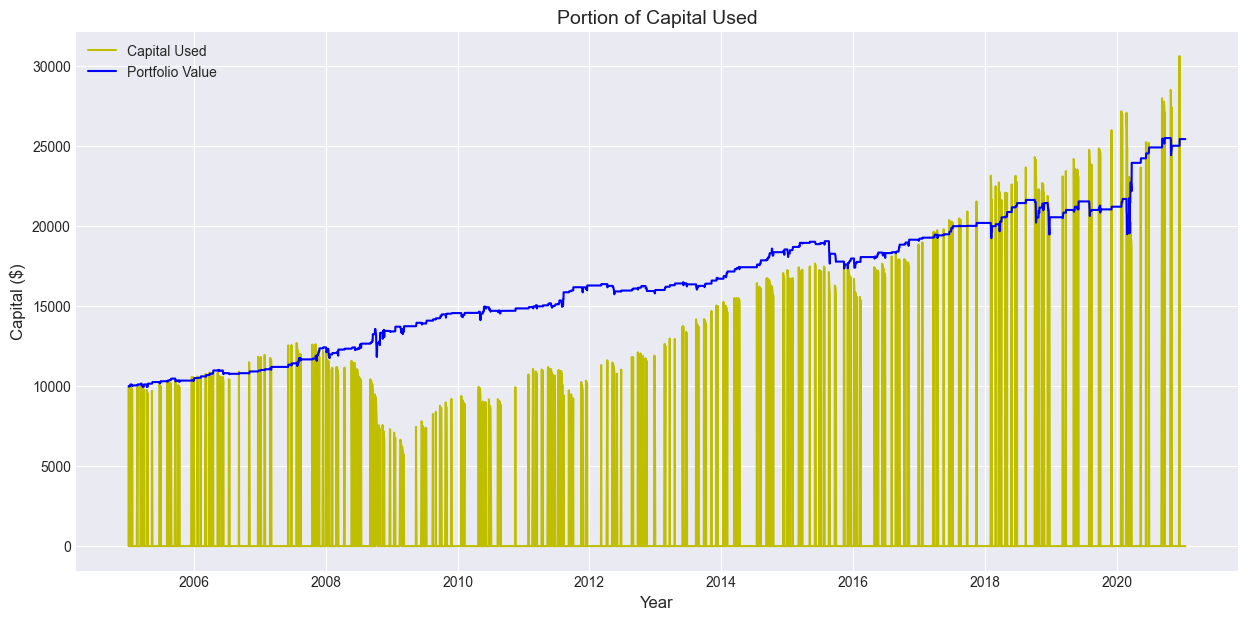

In [6]:
"""
Define the function to plot the capital used.
"""


def plot_portion_of_capital(portion_of_capital_used, total_portfolio_value):
    # Define the plot figure
    plt.figure(figsize=(15, 7))
    plt.plot(portion_of_capital_used, label="Capital Used", color='y')
    plt.plot(total_portfolio_value, label="Portfolio Value", color='blue')

    # Add chart titles and axis labels
    plt.title('Portion of Capital Used', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Capital ($)', fontsize=12)
    plt.legend()
    plt.show()


# Use the plot function
plot_portion_of_capital(
    fixed_units['portion_of_capital'], fixed_units['portfolio_value'])

The fixed units technique traded for fixed units of the asset throughout the backtest. When the asset price reduced, the capital used by the strategy also reduced. Similarly, when the asset price increased, the capital used by this strategy also increased.

<a id='leverage'></a>
## Leverage Ratio
The leverage ratio is the ratio of the wealth used in each trade (`fixed_units['portion_of_capital']`), to the available capital(`fixed_units['portfolio_value']`).

In [7]:
# Leverage ratio
fixed_units['leverage'] = fixed_units['portion_of_capital'] / fixed_units['portfolio_value']

### Leverage Plotting Utility

A function to plot the leverage is defined so that you can easily plot this metric for the upcoming position sizing techniques.

The leverage plotting function is called `plot_leverage`. This function is placed in the `position_sizing_quantra.py` file located in the `data_modules` folder.

The `plot_portion_of_capital` function accepts two arguments.
1. `portion_of_capital_used`: The strategy portfolio value you want to evaluate.
1. `total_portfolio_value`: The benchmark portfolio value to compare the strategy performance. This argument is optional.

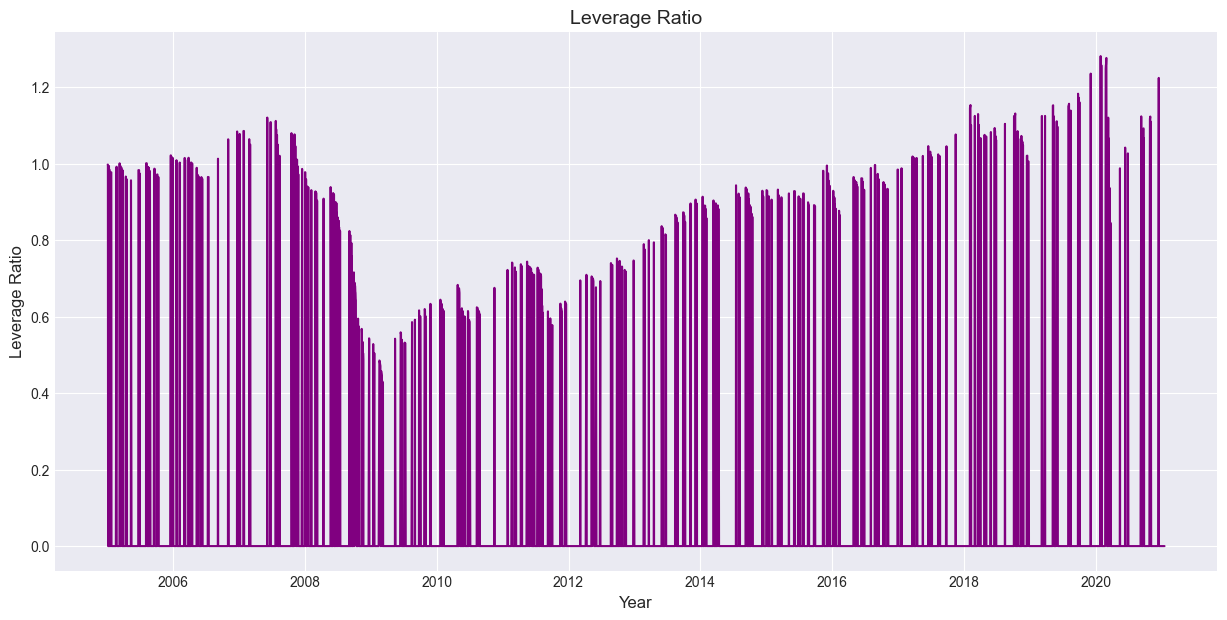

In [8]:
"""
Define the function to plot the capital used.
"""


def plot_leverage(leverage):
    # Plot the leverage ratio
    plt.figure(figsize=(15, 7))
    plt.plot(leverage, color='purple')
    plt.title('Leverage Ratio', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Leverage Ratio', fontsize=12)
    plt.show()
    
# Plot the leverage using the utility function
plot_leverage(fixed_units['leverage'])

The leverage ratio of the fixed units technique was below 1 when the price of the asset dropped below the price on the day of the first trade. Similarly, it was above 1 when the asset price was greater than the first traded price for the strategy. This is because in every trade we purchase the same amount of the asset.

In the upcoming units, you will learn about the fixed sum technique.
<br><br>